# automatically parse solid nmr data

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
sys.path.append("FlowMater")
sys.path.append("IonLib/")

from dataframe_parse import add_unique_IDs
from scipy import fftpack

In [3]:
#data load
df_path="temp/df.bin"
df=joblib.load(df_path)
fp_keys=joblib.load("temp/all_fp_keys.bin")
anal_df=add_unique_IDs(df,fp_keys)

IonLib/dataframe_parse.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anal_df["Anneal"][anal_df["Anneal"] >= 1] = 1


In [4]:
def get_fwhm(x,y):

    ymax=np.max(y)
    max_id=np.where(y==ymax)[0][0]

    check_y=abs(y-ymax/2)

    half_x_range=x[:max_id]
    half_y_range=check_y[:max_id]
    x1_id=np.where(half_y_range==min(half_y_range))
    x1=half_x_range[x1_id]

    half_x_range=x[max_id:]
    half_y_range=check_y[max_id:]
    x2_id=np.where(half_y_range==min(half_y_range))
    x2=half_x_range[x2_id]
    
    return x1[0],x2[0],x[max_id]

#denoise by fft
def remove_noise(target_df,cutoff=0.002,N=10,target_y="Real"):
    y=np.array(target_df[target_y])
    sample_freq =fftpack.fftfreq(target_df.shape[0],d=10)
    sig_fft=fftpack.fft(y)
    sig_fft[np.abs(sample_freq) >cutoff] = 0  
    main_sig =np.real( fftpack.ifft(sig_fft)) 

    new_df=copy.deepcopy(target_df)
    new_df[target_y]=main_sig
    
    return new_df[N:-N]


In [5]:
from scipy.optimize import curve_fit
from scipy import integrate
import copy

def fit_func(x,*params):
    
    #gaussian
    amp_1=params[0]
    mu_1=params[1]
    sigma_1=params[2]
    y=amp_1*np.exp(-((x-mu_1)**2)/2/sigma_1**2)
    
    #lorentz
    amp_2=params[3]
    mu_2=params[4]
    sigma_2=params[5]
    y+=amp_2*(sigma_2**2)/((x-mu_2)**2+sigma_2**2)
    
    return y

def auto_anal(df,x_range=(-10,10),x_name="X",y_name="Real",title=""):

    #set data
    df=df[df[x_name]>x_range[0]]
    df=df[df[x_name]<x_range[1]]

    x=np.array(df[x_name])
    y=np.array(df[y_name])

    #calc fwhm and peak
    x1,x2,peak=get_fwhm(x,y)

    #plot
    plt.figure()
    
    plt.plot(x,y,label=1,alpha=0.4)
    ymax=np.max(y)
    plt.plot([x1,x2],[ymax/2,ymax/2],label=1,alpha=0.4)
    
    plt.title(title)

    peak_pos=peak
    fwhm=abs(x2-x1)

    parsed_dict={}

    parsed_dict["Peak position (ppm)"]=peak_pos
    parsed_dict["Peak FWHM (ppm)"]=fwhm
    

    return parsed_dict

In [6]:
processed_df=copy.copy(df)

In [7]:
#denoise some noisy data

exceptional_dict={}
exceptional_dict['normal_experiment75_graph_integrated_json_0_database/experiments/MU/nmr/1209/no1_lifsi/nmr.graphml']=(0.0008,(-90,-50))
exceptional_dict['normal_experiment75_graph_integrated_json_1_database/experiments/MU/nmr/1209/no1_lifsi/nmr.graphml']=(0.0008,(-90,-60))

exceptional_dict['normal_experiment76_graph_integrated_json_0_database/experiments/MU/nmr/1209/no2_ppo_chloranil_lifsi/nmr.graphml']=(0.01,None)
exceptional_dict['normal_experiment76_graph_integrated_json_1_database/experiments/MU/nmr/1209/no2_ppo_chloranil_lifsi/nmr.graphml']=(0.01,None)


exceptional_dict['normal_experiment77_graph_integrated_json_0_database/experiments/MU/nmr/1209/no3_libf4/nmr.graphml']=(0.0008,(-190,-160))
exceptional_dict['normal_experiment77_graph_integrated_json_1_database/experiments/MU/nmr/1209/no3_libf4/nmr.graphml']=(0.0008,(-200,-100))

exceptional_dict['normal_experiment78_graph_integrated_json_0_database/experiments/MU/nmr/1209/no4_ppo_chloranil_libf4/nmr.graphml']=(0.0008,(-300,-50))
exceptional_dict['normal_experiment78_graph_integrated_json_1_database/experiments/MU/nmr/1209/no4_ppo_chloranil_libf4/nmr.graphml']=(0.0008,(-300,-50))




In [8]:
processed_df[processed_df["solid_NMR_load_data"]=="path not found"][["solid_NMR_keyword"]]

,solid_NMR_keyword
normal_experiment72_graph_integrated_json_0_database/experiments/MU/nmr/0106T1/no2/nmr.graphml,solid_F_MAS_nmr


/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


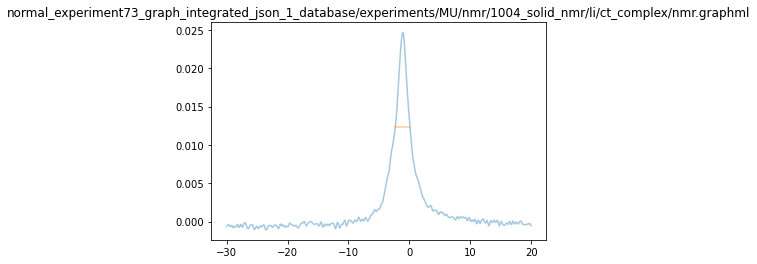

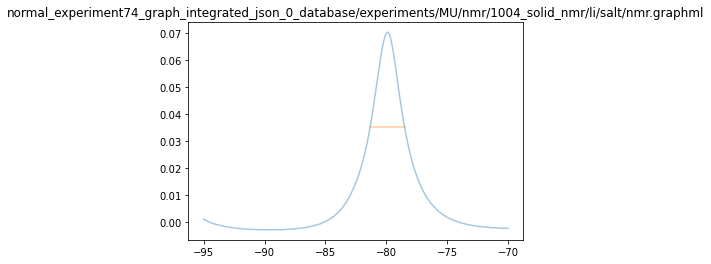

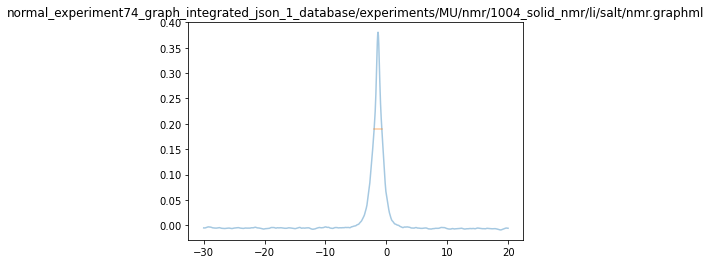

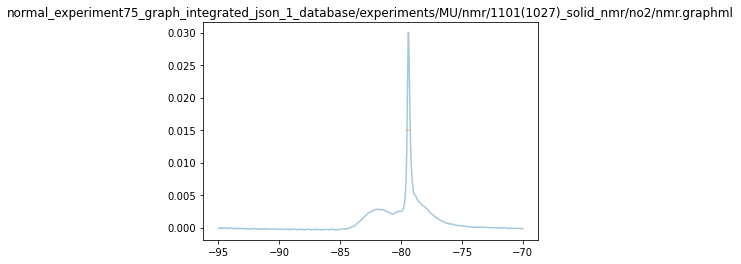

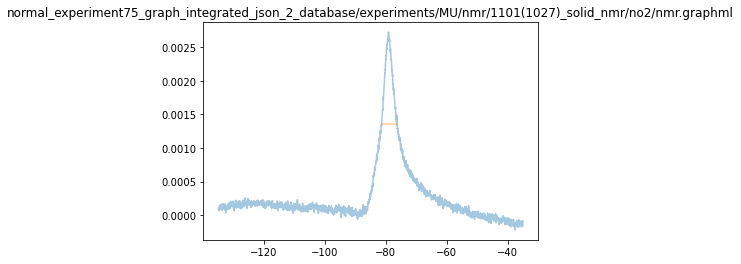

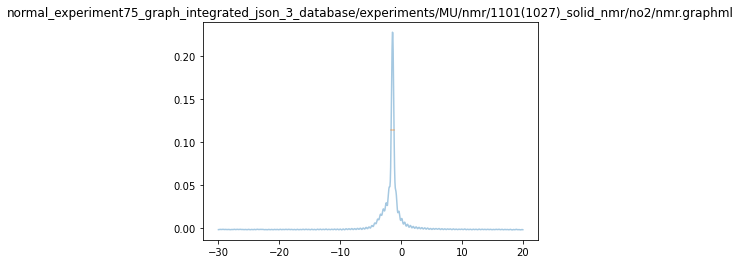

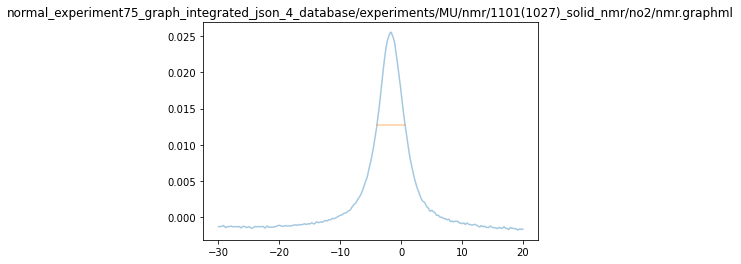

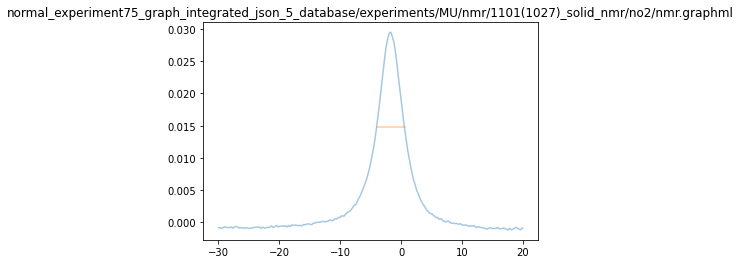

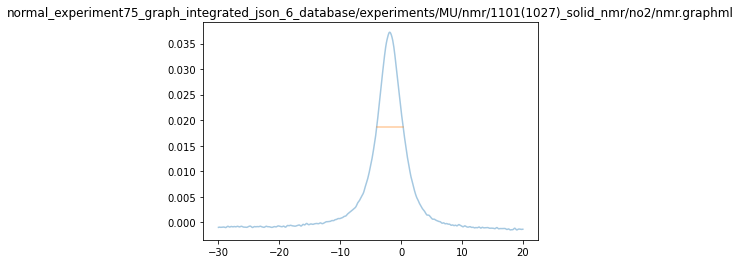

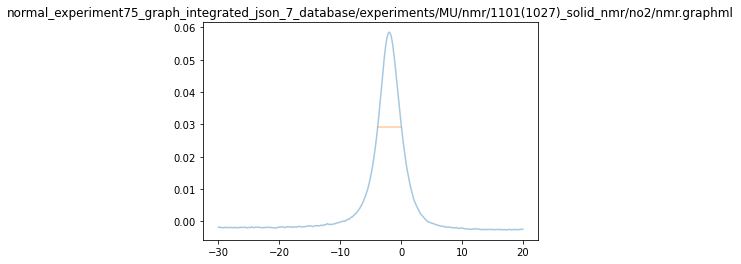

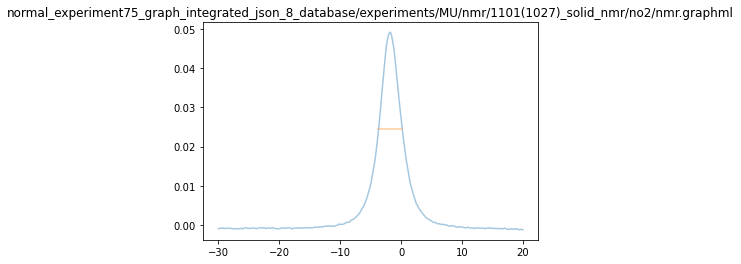

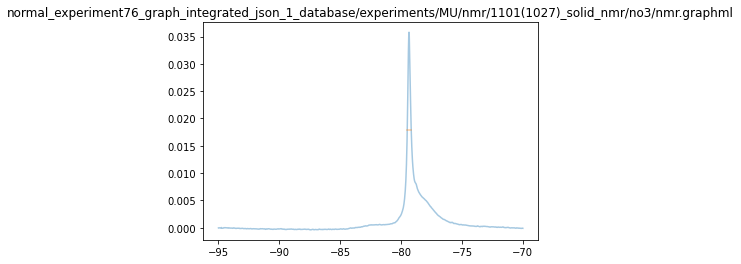

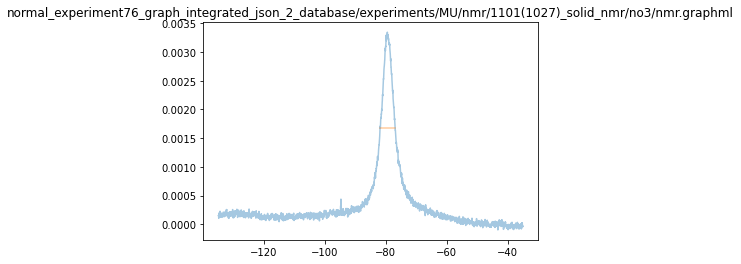

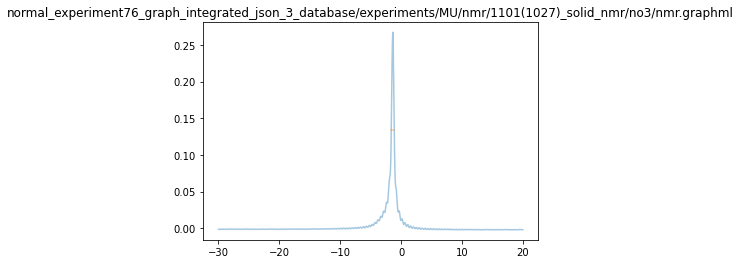

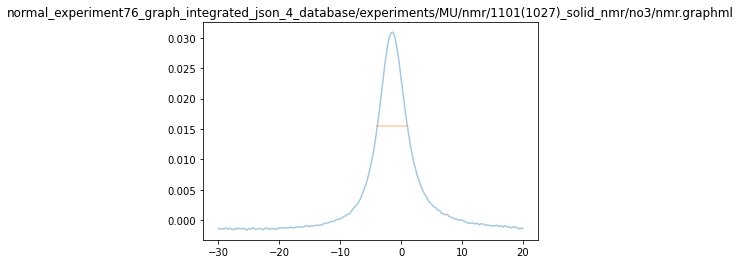

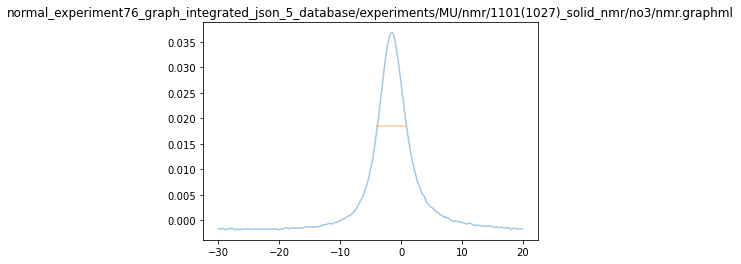

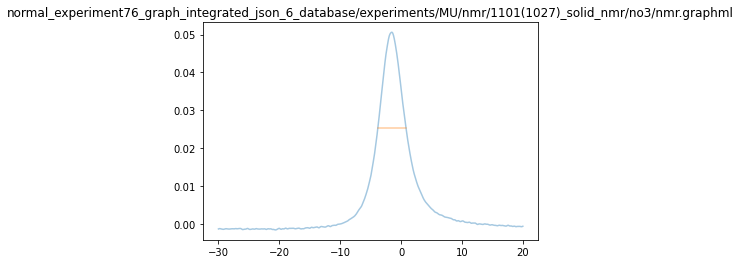

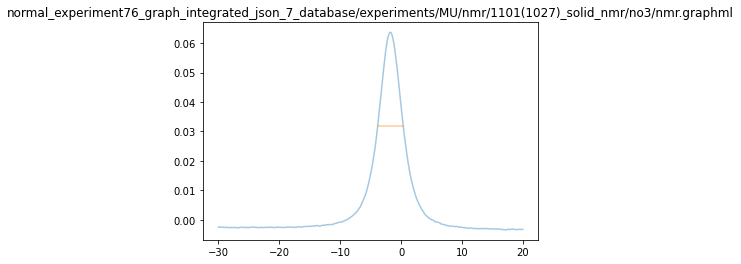

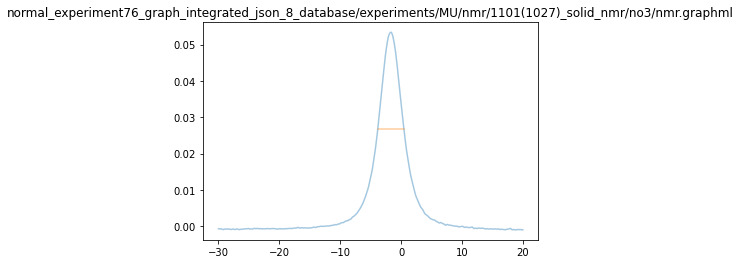

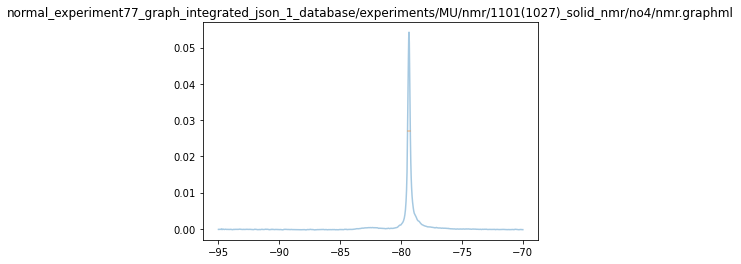

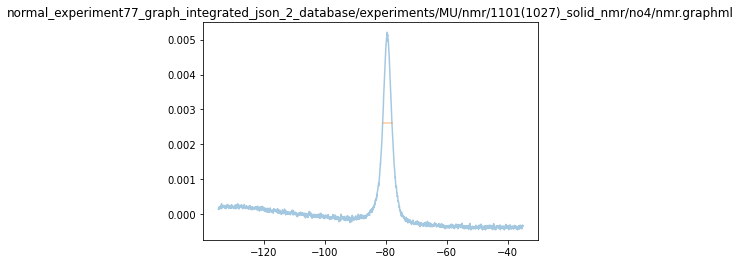

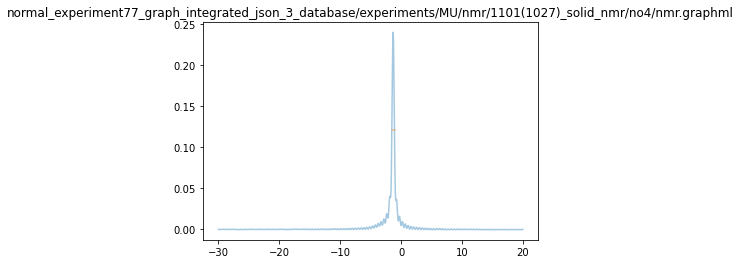

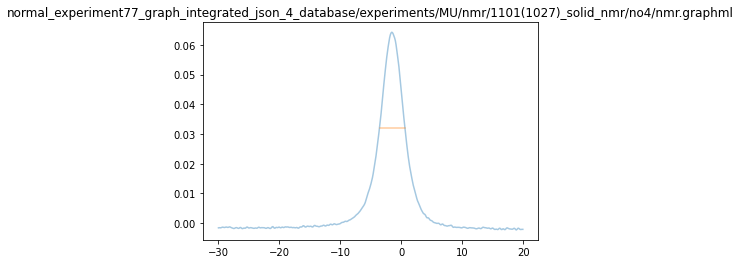

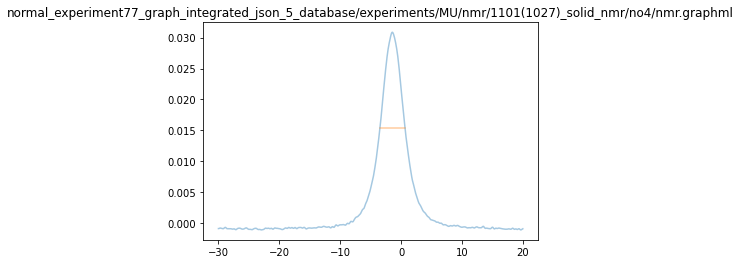

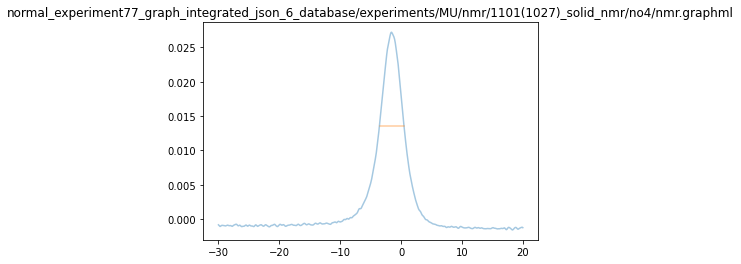

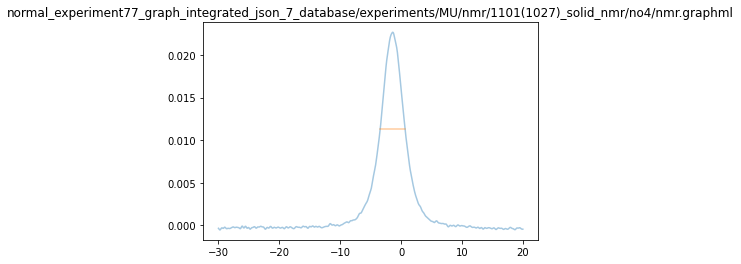

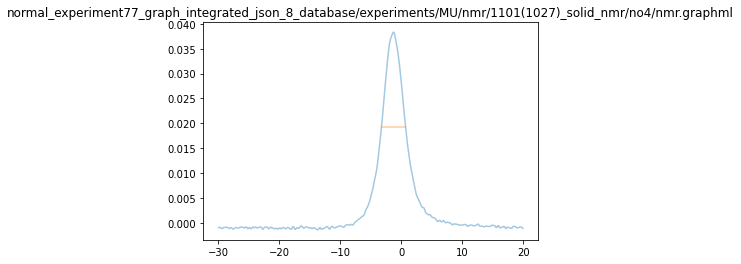

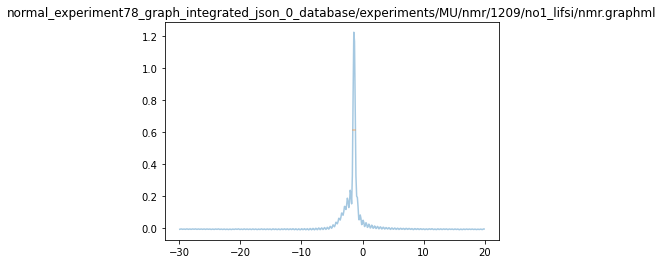

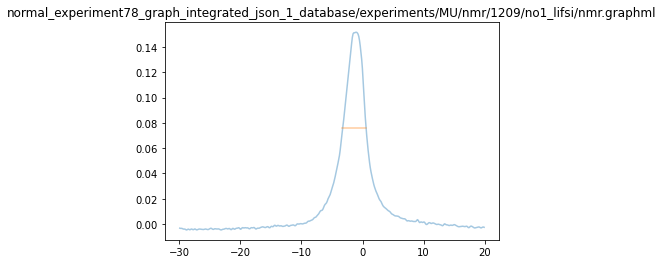

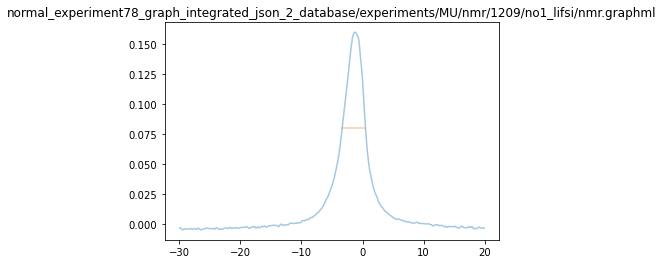

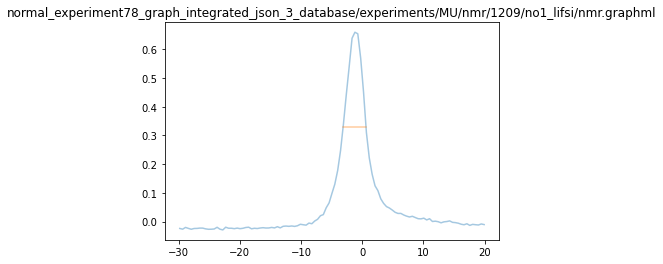

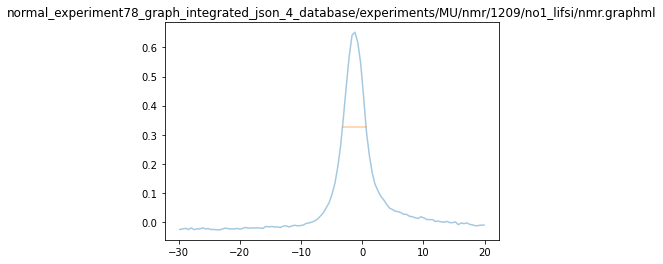

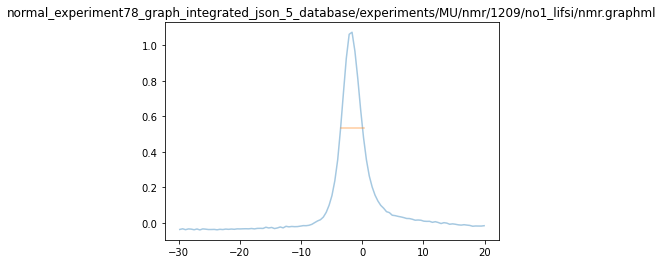

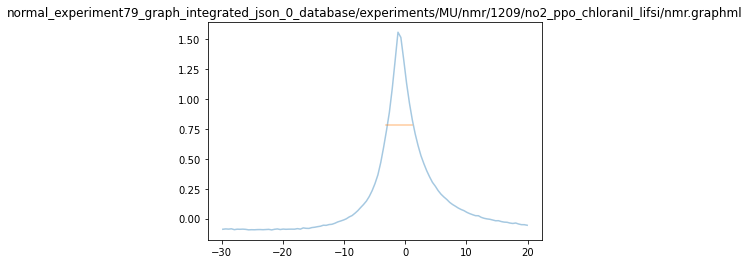

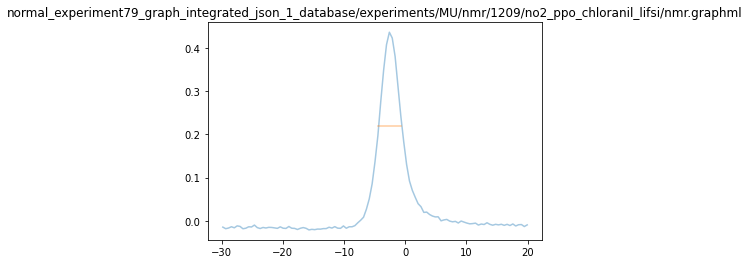

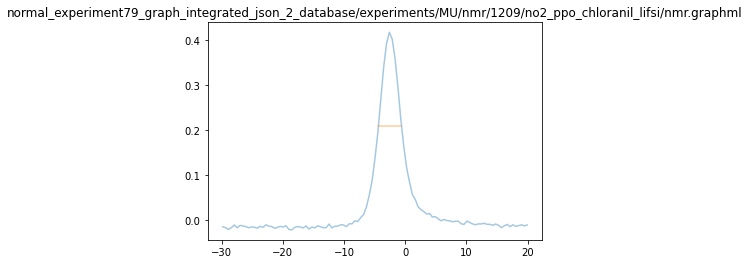

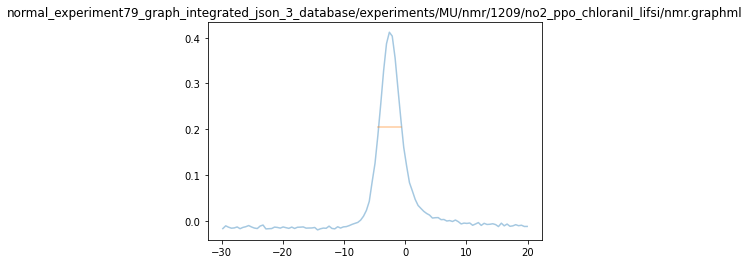

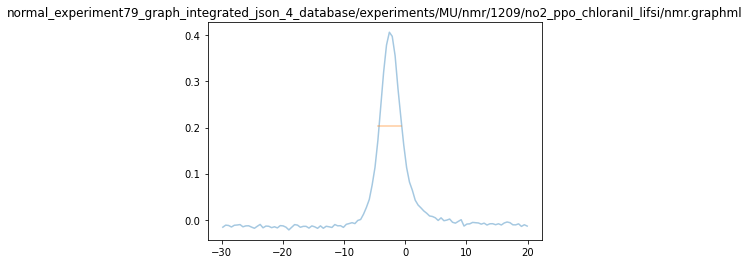

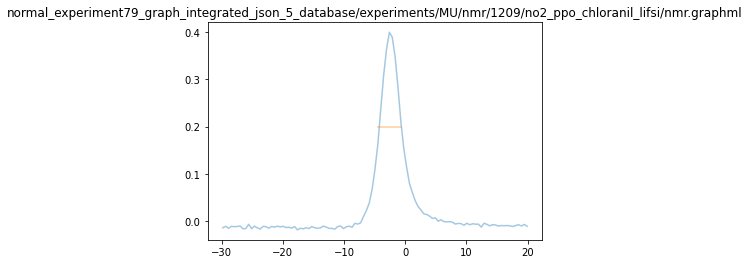

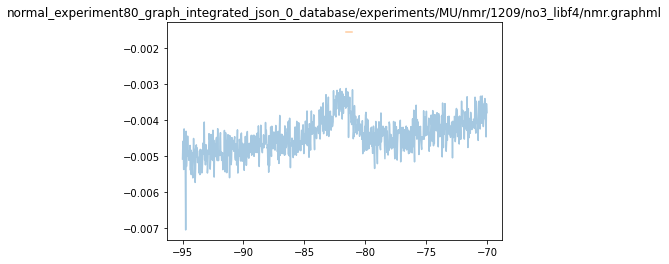

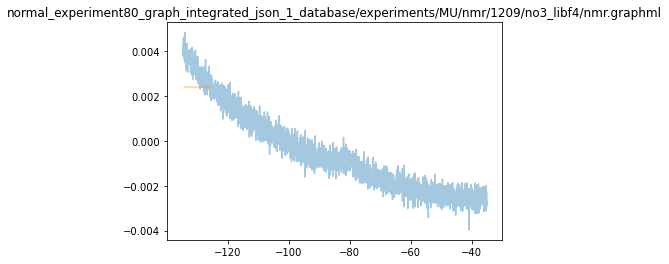

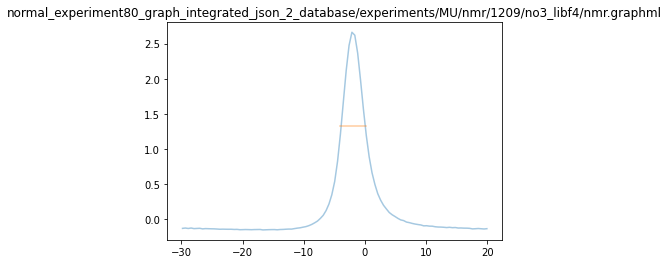

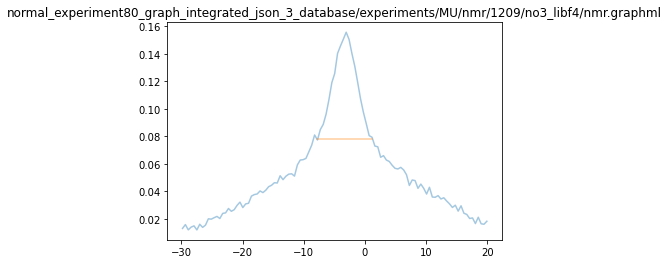

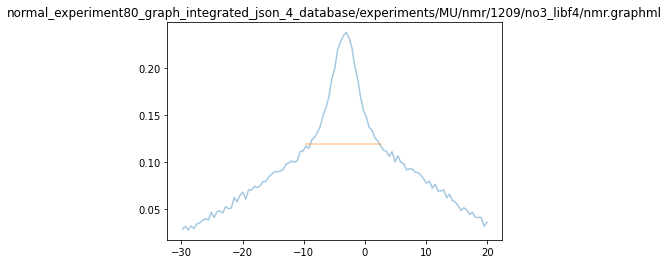

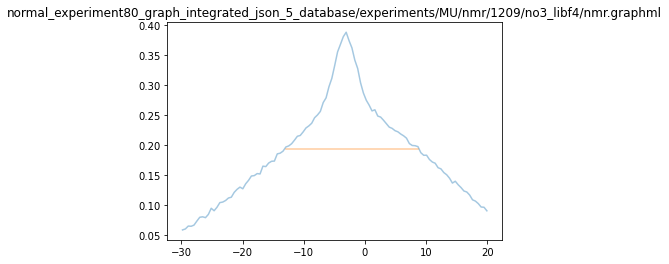

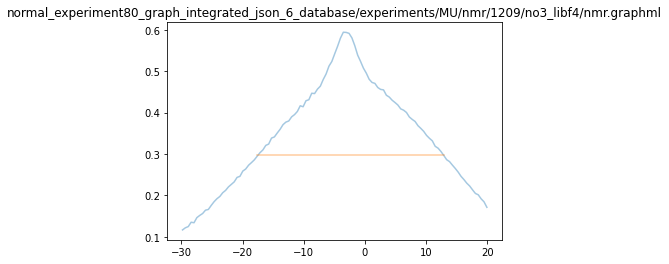

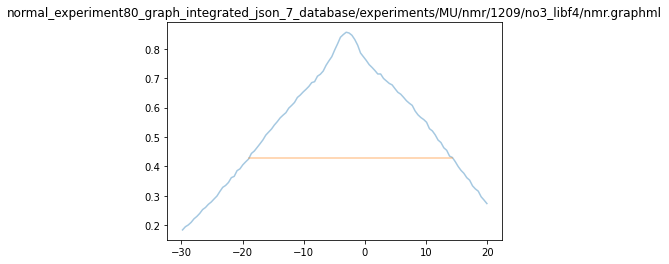

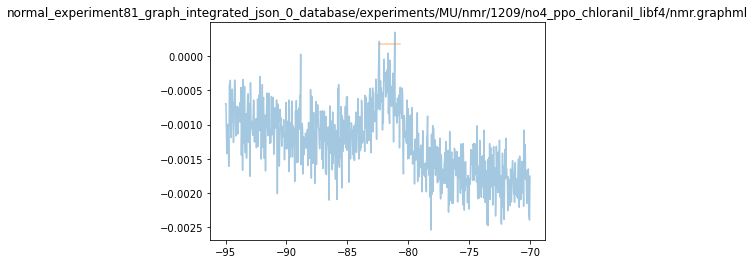

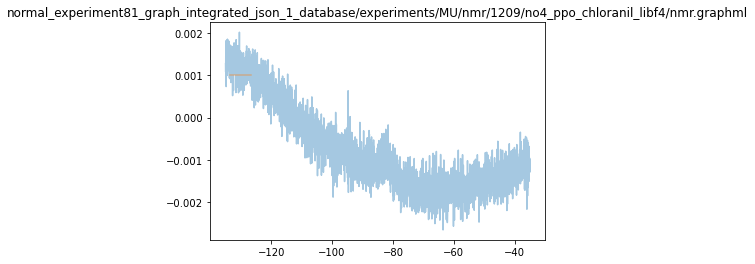

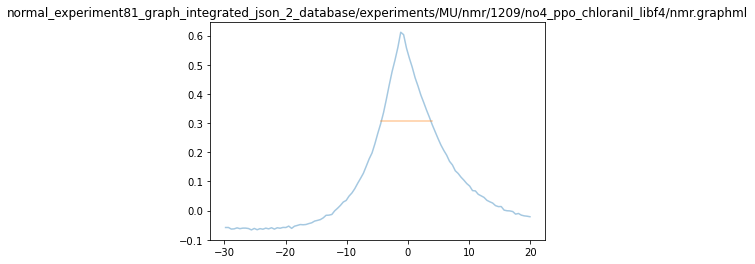

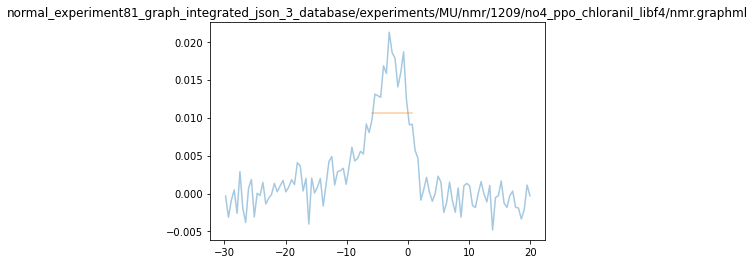

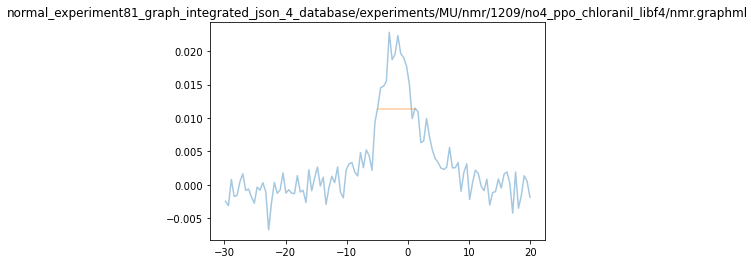

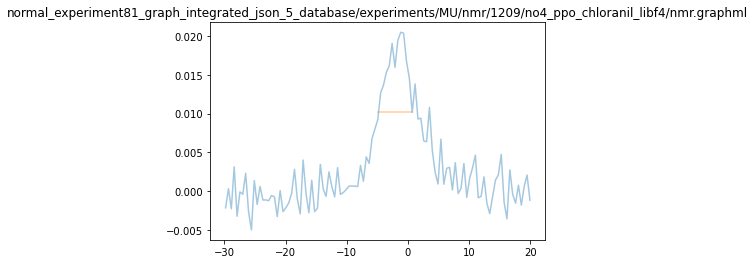

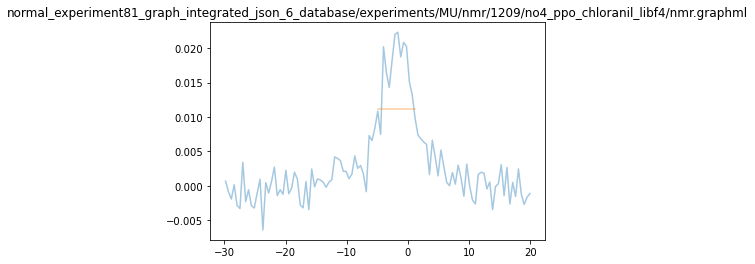

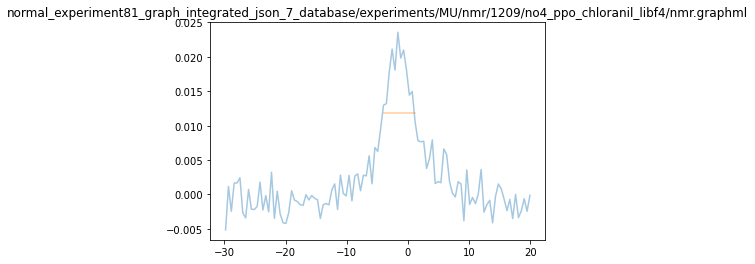

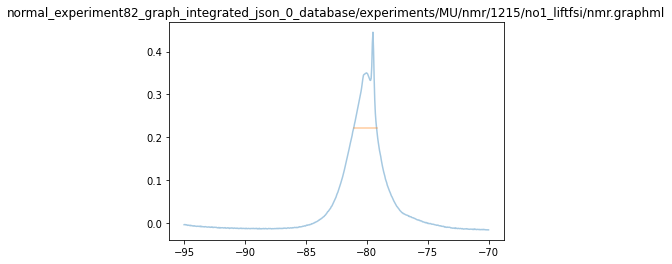

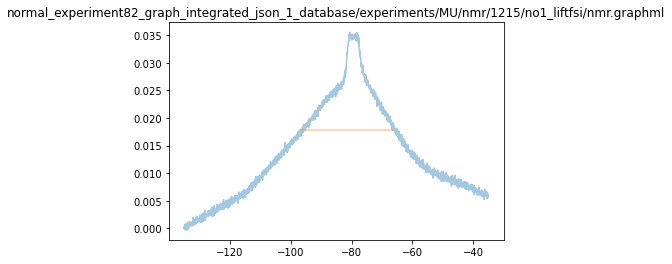

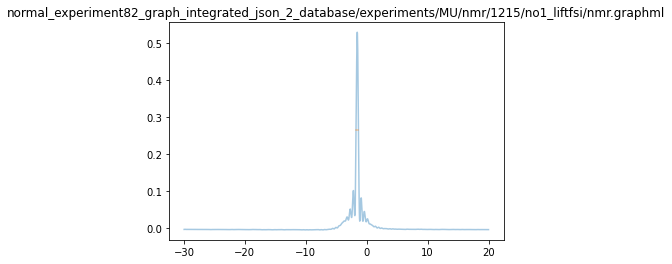

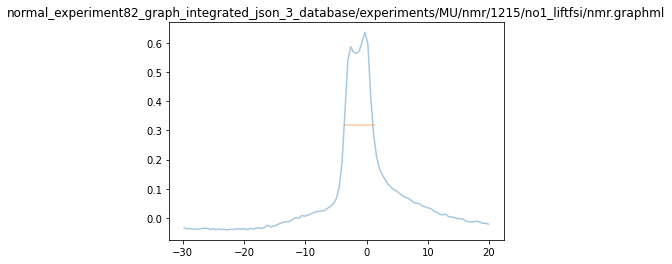

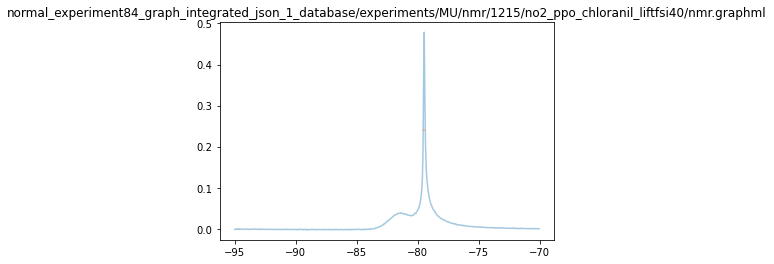

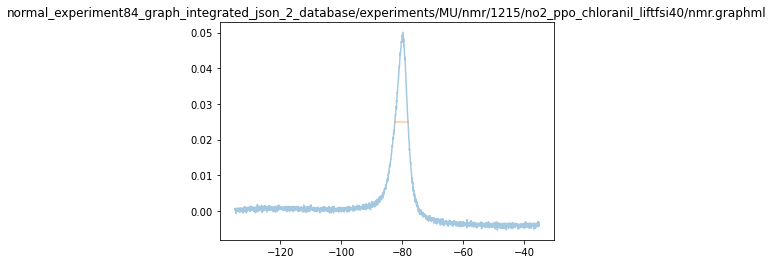

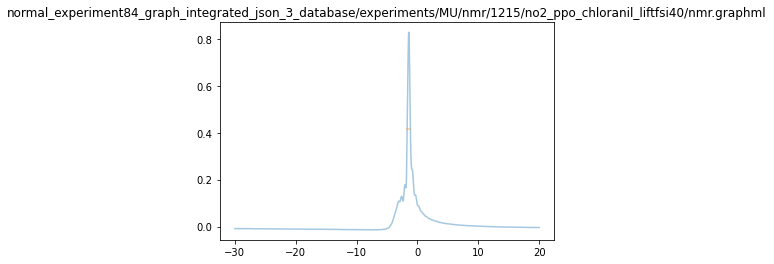

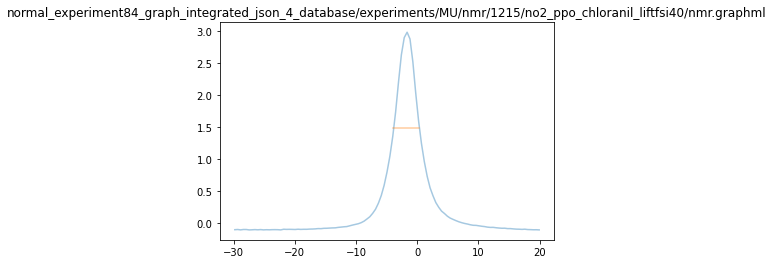

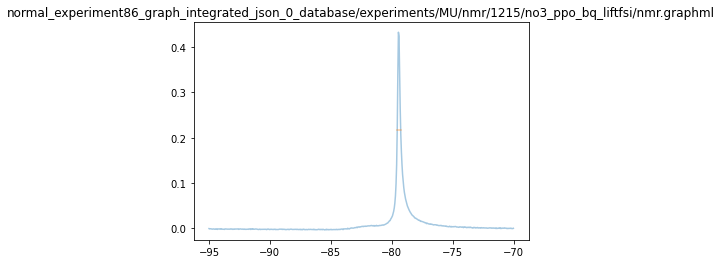

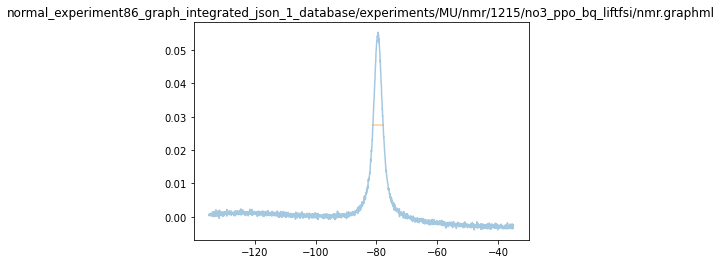

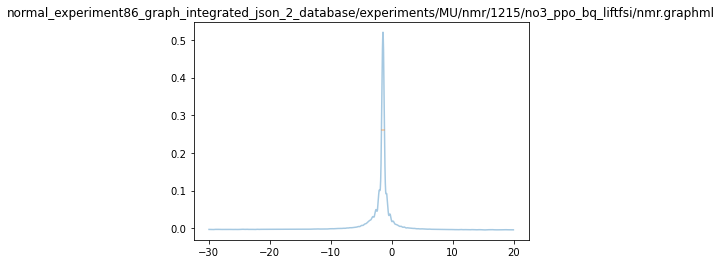

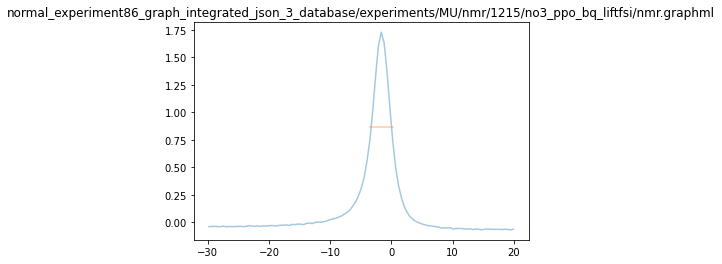

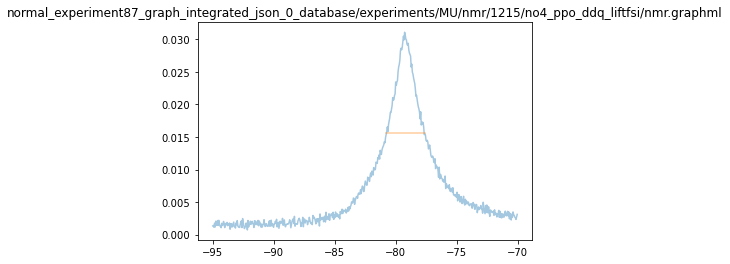

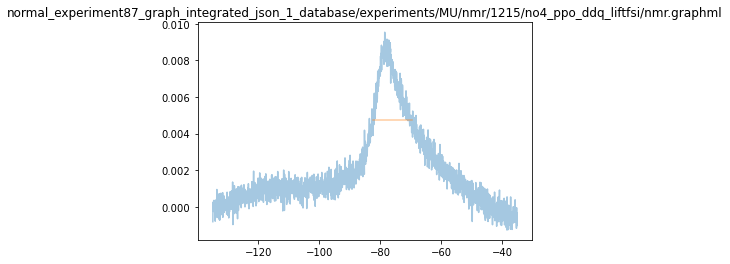

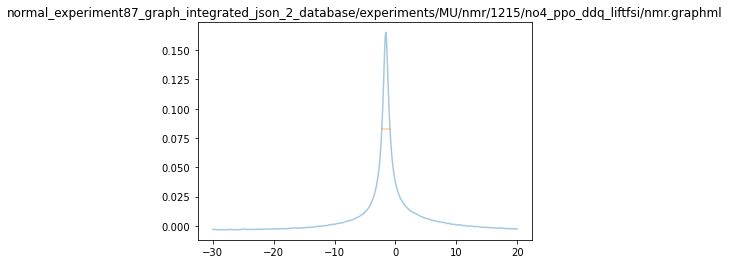

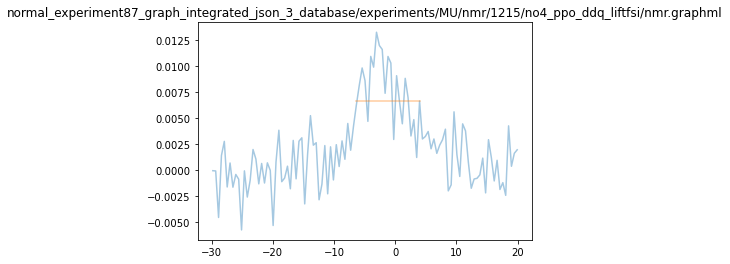

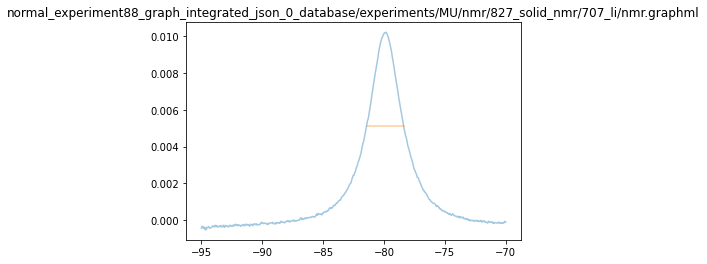

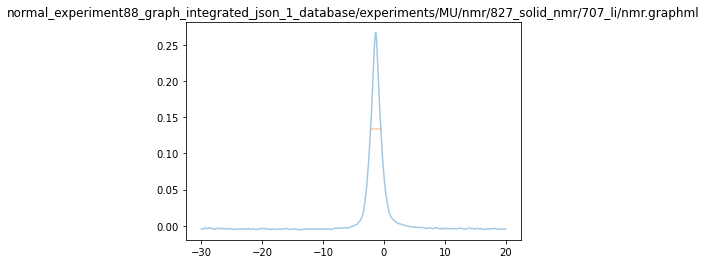

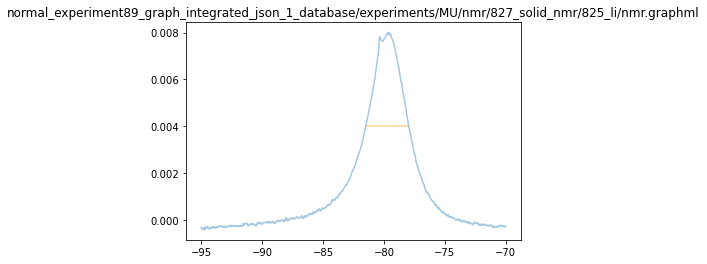

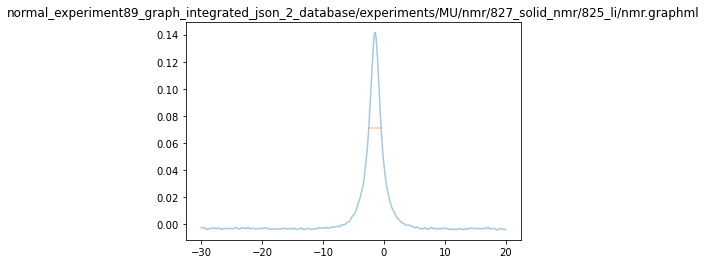

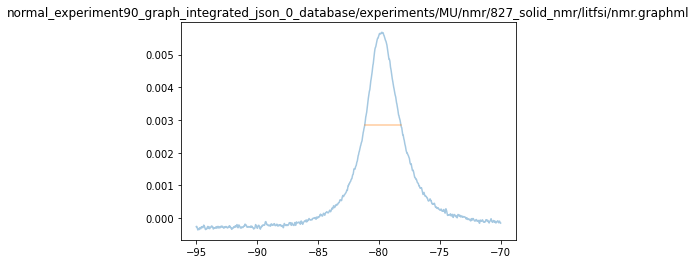

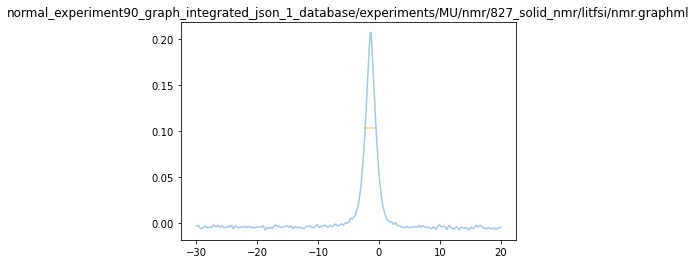

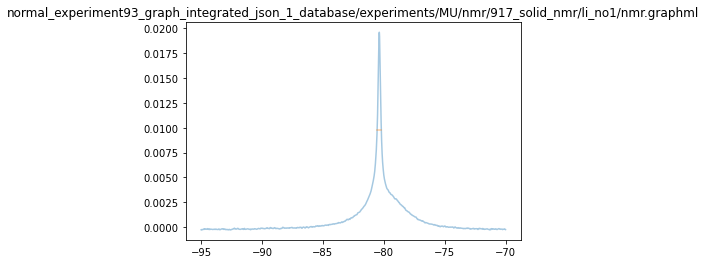

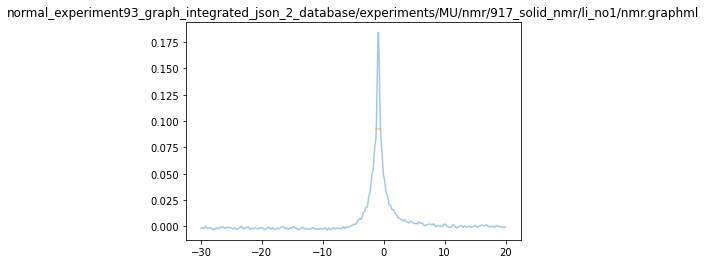

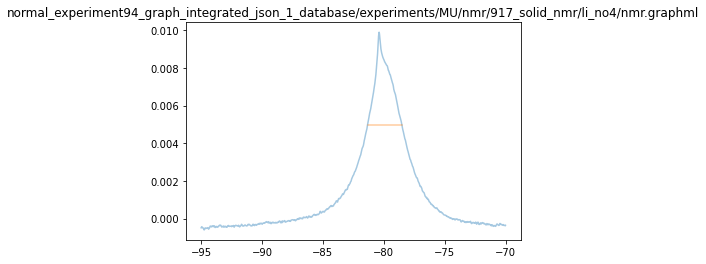

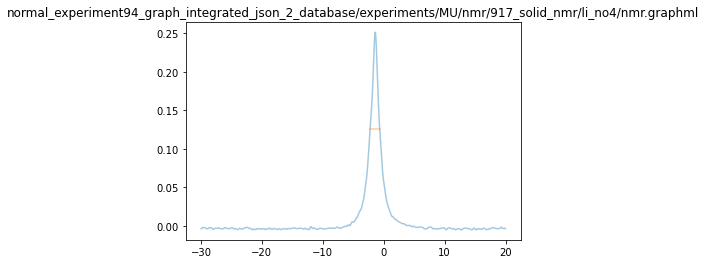

In [9]:
#load nmr data
nmr_dict={}
raw_data_dict={}

for i in range(processed_df.shape[0]):
    if not processed_df["solid_NMR_load_data"][i]==processed_df["solid_NMR_load_data"][i]:
        continue
    data_path=processed_df["solid_NMR_load_data"][i]

    if data_path.find(".asc")<0:
        continue
        
    data_df=pd.read_csv(data_path,sep='\t')
    ind=processed_df.index[i]
 
    #calibrate offset
    offset=processed_df["solid_NMR_offset"][i]
    if type(offset) is str:
        offset=offset.replace(" ppm","")
        offset=float(offset)
        data_df["X"]=data_df["X"]+offset
    
    #denoise some noisy data
    x_range=None
    if ind in exceptional_dict:
        cutoff,x_range=exceptional_dict[ind]
        #data_df=remove_noise(data_df,cutoff=cutoff)
        
    raw_data_dict[ind]=data_df
    nmr_type=processed_df["solid_NMR_keyword"][i]
    
    parsed_dict={}
    
    if x_range is None:
        if nmr_type in ["solid_Li_MAS_nmr","solid_Li_static_nmr"]:
            x_range=(-30,20)
        elif nmr_type in ["solid_F_static_nmr"]:
            x_range=(-135,-35)
        elif nmr_type in ["solid_F_MAS_nmr"]:
            x_range=(-95,-70)
    
    if x_range is not None:
        parsed_dict=auto_anal(data_df,x_range=x_range,title=ind)    

        
    if parsed_dict:
        modif_parsed_dict={}
        for k,v in parsed_dict.items():
            name=nmr_type+"_"+k
            name=name.replace("solid_","")
            name=name.replace("_nmr","")
            name=name.replace("_MAS","(MAS)")
            name=name.replace("_static","(Static)")
            name=name.replace("_Peak",":")
            name=name.replace("position","$\delta$")
            modif_parsed_dict[name]=v
            
        #save data only at 25oC (for this version)
        if processed_df.at[ind,"solid_NMR_Temperature"]==25:
            nmr_dict[ind]=modif_parsed_dict
        #for k,v in parsed_dict.items():
        #    processed_df.at[ind,nmr_type+"_"+k]=v
            

In [10]:
#data_path

In [11]:
joblib.dump(nmr_dict,"temp/parsed/nmr_anal.bin")

['temp/parsed/nmr_anal.bin']

In [12]:
#list(nmr_dict.keys())
#nmr_dict

# Visualization

In [13]:
interested_conditions=["manual condition",'solid_NMR_keyword',
 'solid_NMR_Temperature',
 'solid_NMR_MAS rate',
"solid_NMR_load_data"]

sel_df=anal_df[anal_df["solid_NMR_load_data"]==anal_df["solid_NMR_load_data"]]
sel_df=sel_df[sel_df["solid_NMR_load_data"].str.find(".asc")>0]
sel_df=sel_df[interested_conditions]


In [14]:
#data load
plot_nmr_dict={}

for i in range(sel_df.shape[0]):
    ind=sel_df.index[i]
    electrolyte=sel_df["manual condition"][i]
    nmr_cond=sel_df["solid_NMR_keyword"][i]
    plot_nmr_dict[electrolyte+":"+nmr_cond]=raw_data_dict[ind]

In [15]:
x_range=(-90,-75)
x_name="X"
y_name="Real"

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams["ytick.left"] = False
plt.rcParams["font.size"] = 15


def prepare_fig(figsize=(8,4)):
    plt.figure(figsize=figsize,dpi=100)
    #plt.yticks([],color="w")
    plt.xlabel("Chemical shift (ppm)")
    plt.ylabel("Intensity (-)")

    
def auto_plot(current_df,nmr_cond,x_range=(-10,10),x_name="X",y_name="Real",
              scale=1,
              offset=0,
              alpha=0.7):

    for i in range(current_df.shape[0]):
        electrolyte=current_df["manual condition"][i]
        data_df=plot_nmr_dict[electrolyte+":"+nmr_cond]
        data_df=data_df[data_df[x_name]>x_range[0]]
        data_df=data_df[data_df[x_name]<x_range[1]]
        
        #data_df[y_name]=data_df[y_name]/max(data_df[y_name])
        x=np.array(data_df[x_name])
        y=np.array(data_df[y_name])*scale+offset
        
        label=electrolyte.replace("LG","")
        label=label.replace("D100","LiTFSI")
        label=label.replace("M100","LiFTFSI")
        label=label.replace("N100","LiFSI")
        label=label.replace("B100","LiBF$_{4}$")
        
        
        plt.plot(x,y,label=label,alpha=alpha,linewidth=1)
        
    plt.xlim(x_range[1],x_range[0])
    plt.yticks([])        
    #plt.legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=18)
    


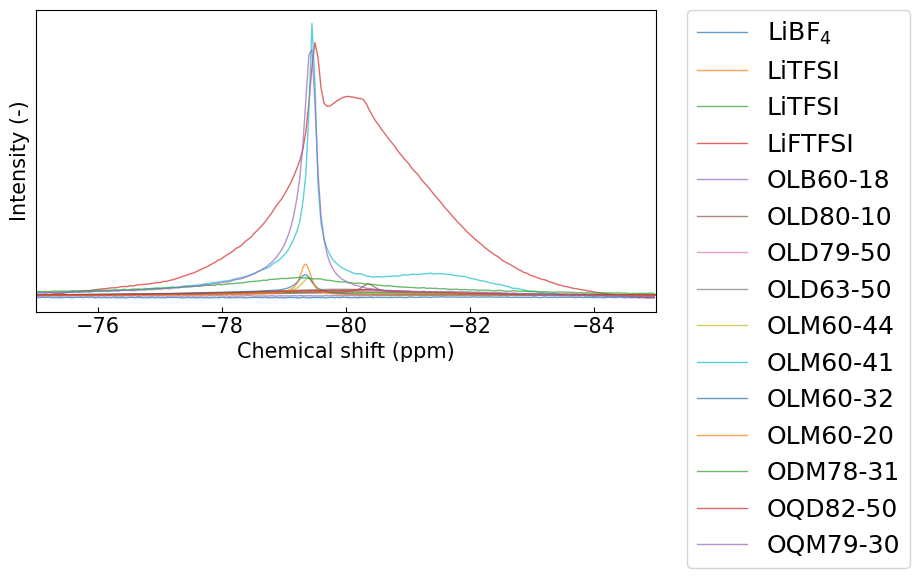

In [16]:
#MAS-F-NMR
nmr_cond="solid_F_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
prepare_fig()
auto_plot(current_df,nmr_cond,x_range=(-85,-75))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


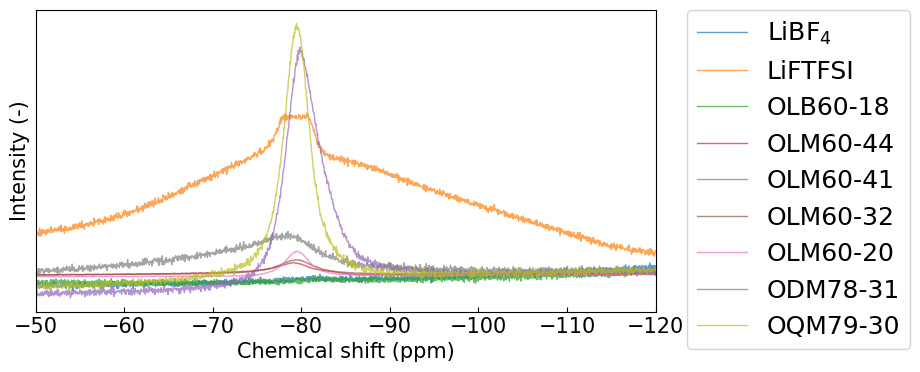

In [17]:

nmr_cond="solid_F_static_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]

prepare_fig(figsize=(8,4))
auto_plot(current_df,nmr_cond,x_range=(-120,-50))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


# plot selected data

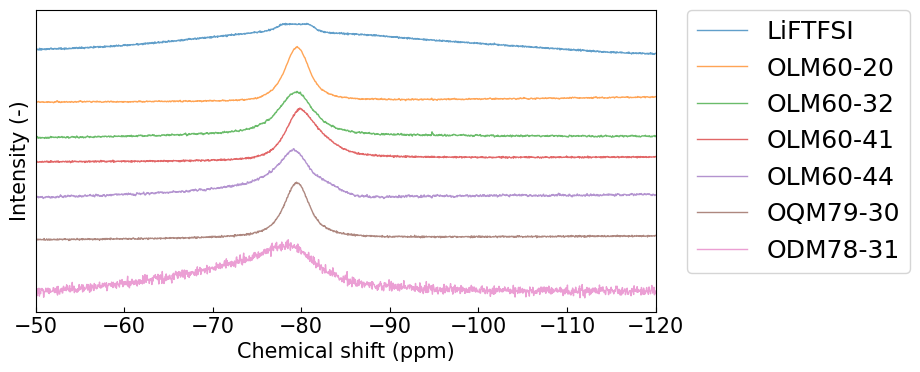

In [18]:
nmr_cond="solid_F_static_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]

prepare_fig(figsize=(8,4))
x_range=(-120,-50)
auto_plot(current_df[current_df["manual condition"].str.find("M100")>=0],nmr_cond,x_range=x_range,scale=0.1,offset=0.012)

auto_plot(current_df[current_df["manual condition"].str.find("OLM60-20")>=0],nmr_cond,x_range=x_range,scale=1,offset=0.008)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-32")>=0],nmr_cond,x_range=x_range,scale=1.4,offset=0.004)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-41")>=0],nmr_cond,x_range=x_range,scale=0.1,offset=0.002)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-44")>=0],nmr_cond,x_range=x_range,scale=1.8,offset=-0.002)
auto_plot(current_df[current_df["manual condition"].str.find("OQM79-30")>=0],nmr_cond,x_range=x_range,scale=0.1,offset=-0.006)
auto_plot(current_df[current_df["manual condition"].str.find("ODM78-31")>=0],nmr_cond,x_range=x_range,scale=0.6,offset=-0.012)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


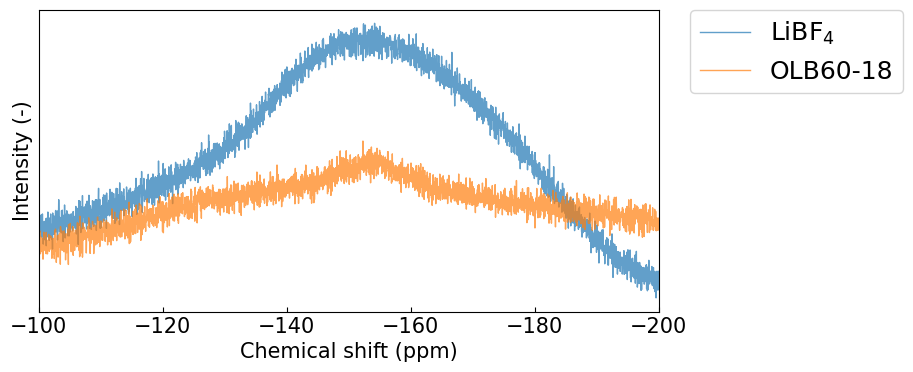

In [19]:
current_df2=current_df[current_df["manual condition"].str.find("B")>=0]
current_df2=current_df2.sort_values(by="manual condition")
prepare_fig(figsize=(8,4))
auto_plot(current_df2,nmr_cond,x_range=(-200,-100))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


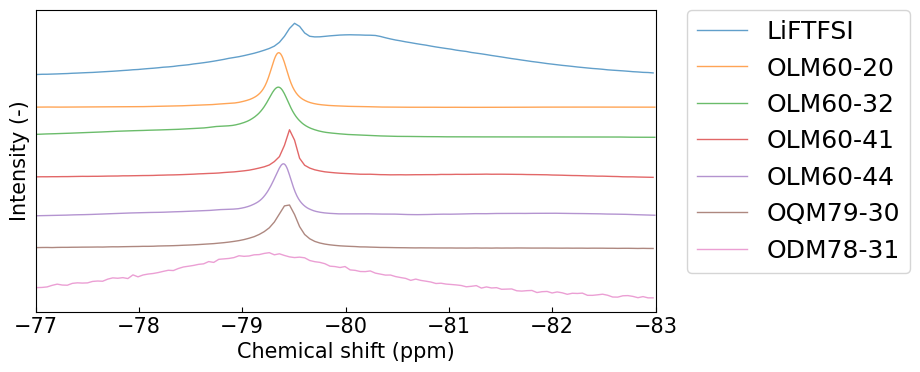

In [20]:
nmr_cond="solid_F_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
x_range=(-83,-77)

prepare_fig(figsize=(8,4))
auto_plot(current_df[current_df["manual condition"].str.find("M100")>=0],nmr_cond,x_range=x_range,scale=0.12,offset=0.08)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-20")>=0],nmr_cond,x_range=x_range,scale=1,offset=0.05)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-32")>=0],nmr_cond,x_range=x_range,scale=1.4,offset=0.02)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-41")>=0],nmr_cond,x_range=x_range,scale=0.1,offset=-0.02)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-44")>=0],nmr_cond,x_range=x_range,scale=1.8,offset=-0.06)
auto_plot(current_df[current_df["manual condition"].str.find("OQM79-30")>=0],nmr_cond,x_range=x_range,scale=0.1,offset=-0.09)
auto_plot(current_df[current_df["manual condition"].str.find("ODM78-31")>=0],nmr_cond,x_range=x_range,scale=1.8,offset=-0.15)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


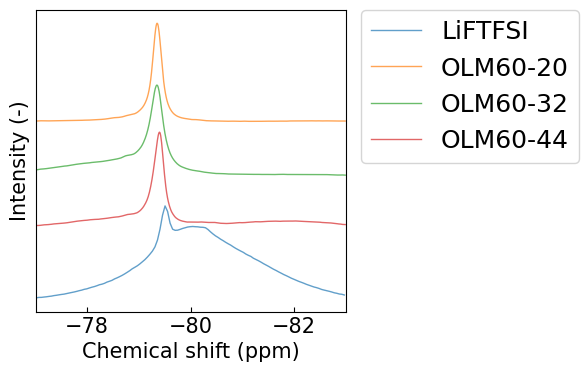

In [21]:
nmr_cond="solid_F_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
x_range=(-83,-77)

prepare_fig(figsize=(4,4))
auto_plot(current_df[current_df["manual condition"].str.find("M100")>=0],nmr_cond,x_range=x_range,scale=0.12,offset=-0.05)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-20")>=0],nmr_cond,x_range=x_range,scale=1,offset=0.05)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-32")>=0],nmr_cond,x_range=x_range,scale=1.4,offset=0.02)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-44")>=0],nmr_cond,x_range=x_range,scale=1.8,offset=-0.01)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


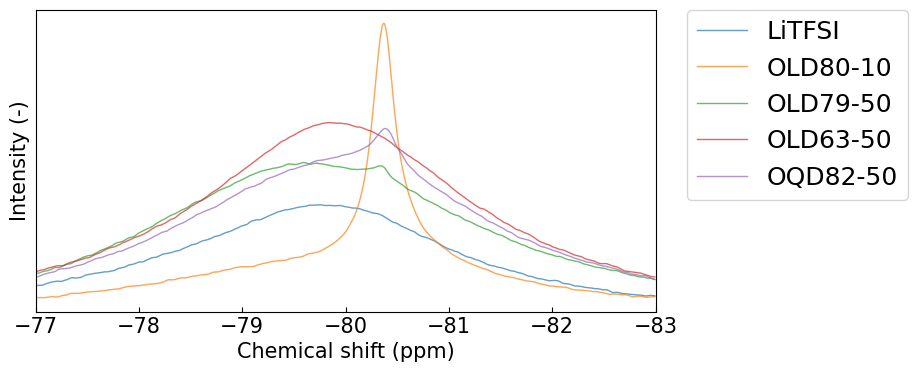

In [22]:
nmr_cond="solid_F_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
x_range=(-83,-77)

prepare_fig(figsize=(8,4))
auto_plot(current_df[current_df["manual condition"].str.find("D100")>=0][0:1],nmr_cond,x_range=x_range,scale=1,offset=0.0)
auto_plot(current_df[current_df["manual condition"].str.find("OLD80-10")>=0],nmr_cond,x_range=x_range,scale=0.8,offset=0.0)
auto_plot(current_df[current_df["manual condition"].str.find("OLD79-50")>=0],nmr_cond,x_range=x_range,scale=1,offset=0.0)
auto_plot(current_df[current_df["manual condition"].str.find("OLD63-50")>=0],nmr_cond,x_range=x_range,scale=1,offset=0.0)
auto_plot(current_df[current_df["manual condition"].str.find("OQD82-50")>=0],nmr_cond,x_range=x_range,scale=1,offset=0.0)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


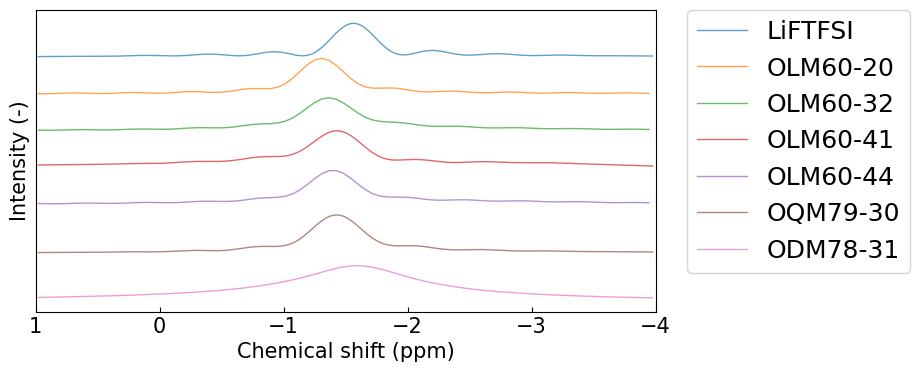

In [23]:
x_range=(-4,1)
nmr_cond="solid_Li_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
current_df=current_df[current_df["solid_NMR_Temperature"]==25]

prepare_fig(figsize=(8,4))
auto_plot(current_df[current_df["manual condition"].str.find("M100")>=0],nmr_cond,x_range=x_range,scale=0.26,offset=0.3)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-20")>=0],nmr_cond,x_range=x_range,scale=0.6,offset=0.15)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-32")>=0],nmr_cond,x_range=x_range,scale=0.5,offset=0)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-41")>=0],nmr_cond,x_range=x_range,scale=0.18,offset=-0.15)
auto_plot(current_df[current_df["manual condition"].str.find("OLM60-44")>=0],nmr_cond,x_range=x_range,scale=0.6,offset=-0.3)
auto_plot(current_df[current_df["manual condition"].str.find("OQM79-30")>=0],nmr_cond,x_range=x_range,scale=0.3,offset=-0.5)
auto_plot(current_df[current_df["manual condition"].str.find("ODM78-31")>=0],nmr_cond,x_range=x_range,scale=0.9,offset=-0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

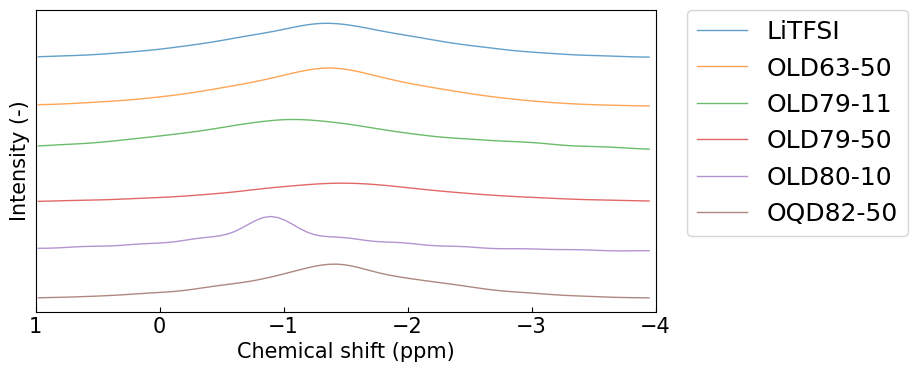

In [24]:
x_range=(-4,1)
nmr_cond="solid_Li_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
current_df=current_df[current_df["solid_NMR_Temperature"]==25]

prepare_fig(figsize=(8,4))
auto_plot(current_df[current_df["manual condition"].str.find("D100")>=0][0:1],nmr_cond,x_range=x_range,scale=0.7,offset=0.9)
auto_plot(current_df[current_df["manual condition"].str.find("OLD63-50")>=0],nmr_cond,x_range=x_range,scale=0.6,offset=0.7)
auto_plot(current_df[current_df["manual condition"].str.find("OLD79-11")>=0],nmr_cond,x_range=x_range,scale=6,offset=0.5)
auto_plot(current_df[current_df["manual condition"].str.find("OLD79-50")>=0],nmr_cond,x_range=x_range,scale=0.6,offset=0.3)
auto_plot(current_df[current_df["manual condition"].str.find("OLD80-10")>=0],nmr_cond,x_range=x_range,scale=0.8,offset=0.1)
auto_plot(current_df[current_df["manual condition"].str.find("OQD82-50")>=0],nmr_cond,x_range=x_range,scale=0.6,offset=-0.1)



plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


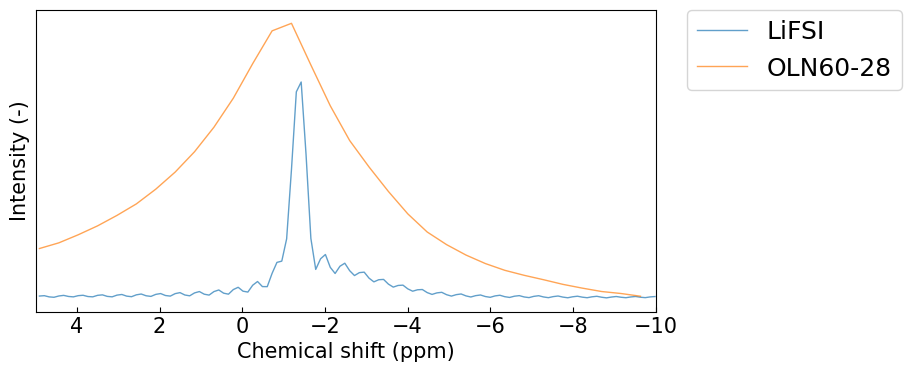

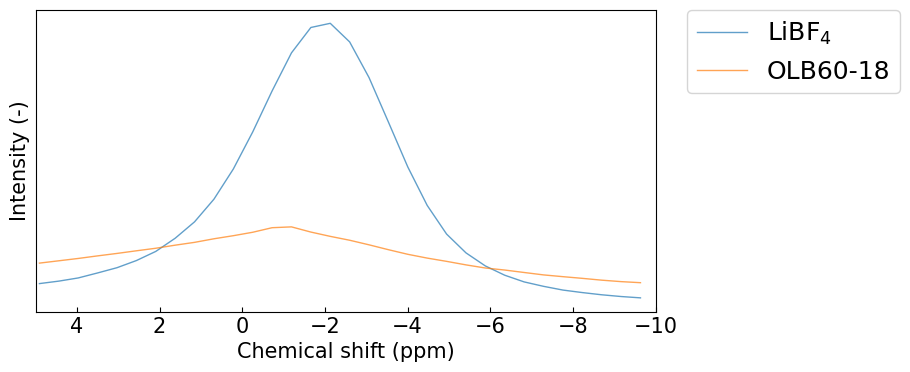

In [25]:
nmr_cond="solid_Li_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
current_df=current_df[current_df["solid_NMR_Temperature"]==25]

current_df2=current_df[current_df["manual condition"].str.find("N")>=0]
current_df2=current_df2.sort_values(by="manual condition")
prepare_fig(figsize=(8,4))
auto_plot(current_df2,nmr_cond,x_range=(-10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

current_df2=current_df[current_df["manual condition"].str.find("B")>=0]
current_df2=current_df2.sort_values(by="manual condition")
prepare_fig(figsize=(8,4))
auto_plot(current_df2,nmr_cond,x_range=(-10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

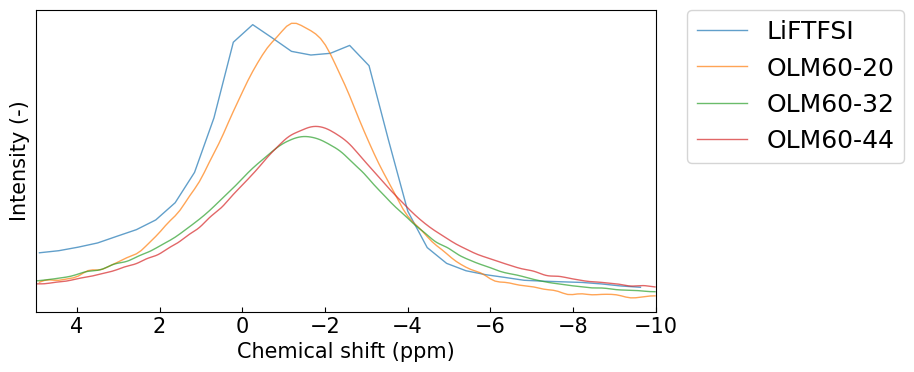

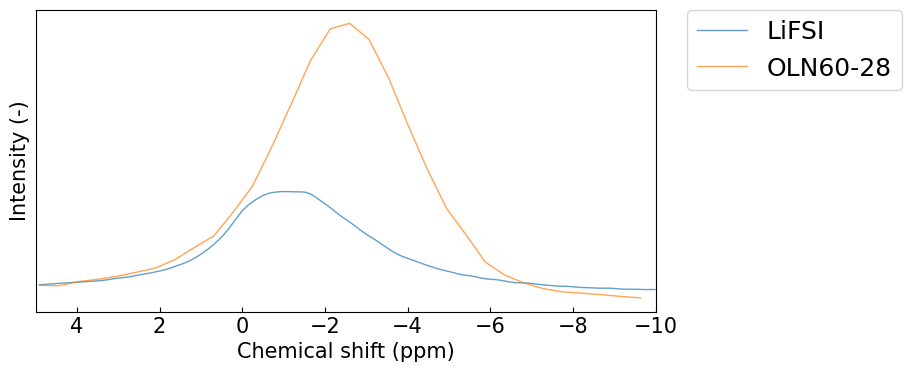

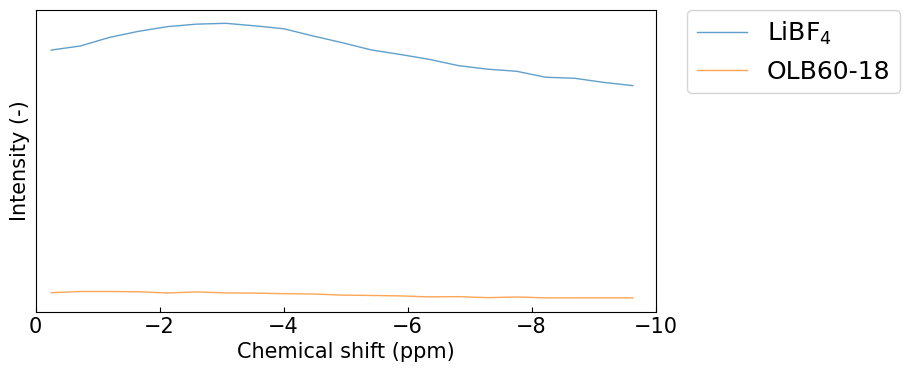

In [26]:
nmr_cond="solid_Li_static_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]
current_df=current_df[current_df["solid_NMR_Temperature"]==25]


prepare_fig(figsize=(8,4))

current_df2=current_df[current_df["manual condition"].str.find("M100")>=0]
auto_plot(current_df2,nmr_cond,x_range=(-10,5),scale=0.06)

current_df2=current_df[current_df["manual condition"].str.find("OLM60-20")>=0]
auto_plot(current_df2,nmr_cond,x_range=(-10,5))

current_df2=current_df[current_df["manual condition"].str.find("OLM60-32")>=0]
auto_plot(current_df2,nmr_cond,x_range=(-10,5),scale=0.6)

current_df2=current_df[current_df["manual condition"].str.find("OLM60-44")>=0]
auto_plot(current_df2,nmr_cond,x_range=(-10,5),scale=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)


current_df2=current_df[current_df["manual condition"].str.find("N")>=0]
current_df2=current_df2.sort_values(by="manual condition")
prepare_fig(figsize=(8,4))
auto_plot(current_df2,nmr_cond,x_range=(-10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

current_df2=current_df[current_df["manual condition"].str.find("B")>=0]
current_df2=current_df2.sort_values(by="manual condition")
prepare_fig(figsize=(8,4))
auto_plot(current_df2,nmr_cond,x_range=(-10,0))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

# carbon nmr

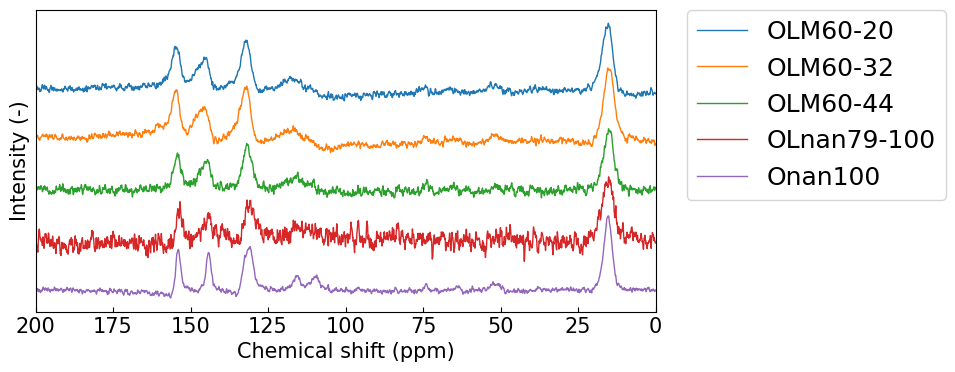

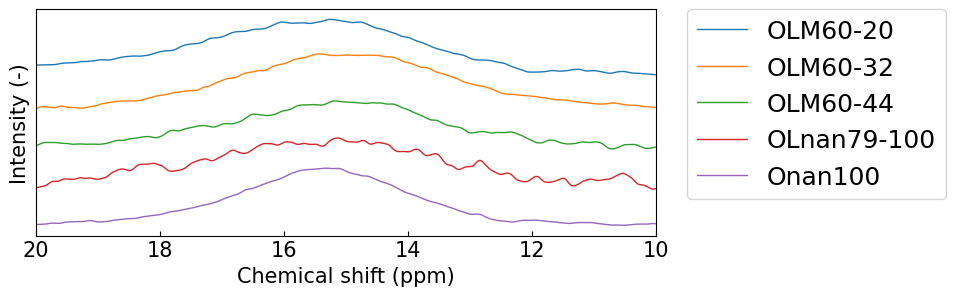

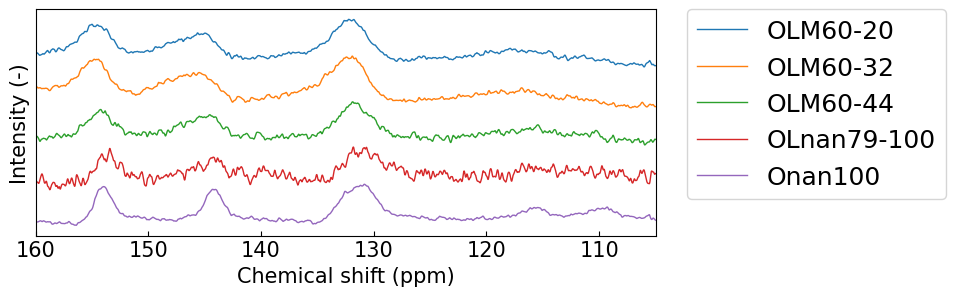

In [27]:
nmr_cond="solid_C_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]

def m_carbon_plot(x_range):
    current_df2=current_df[current_df["manual condition"].str.find("20")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),offset=0.04,alpha=1)

    current_df2=current_df[current_df["manual condition"].str.find("32")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),offset=0.02,alpha=1)

    current_df2=current_df[current_df["manual condition"].str.find("44")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),scale=1.5,offset=0,alpha=1)

    current_df2=current_df[current_df["manual condition"].str.find("nan79")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),scale=3.5,alpha=1,offset=-0.02)

    current_df2=current_df[current_df["manual condition"].str.find("nan100")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),scale=0.07,alpha=1,offset=-0.04)

    plt.yticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

    
x_range=(0,200)
prepare_fig(figsize=(8,4))
m_carbon_plot(x_range)


x_range=(10,20)
prepare_fig(figsize=(8,3))
m_carbon_plot(x_range)

x_range=(105,160)
prepare_fig(figsize=(8,3))
m_carbon_plot(x_range)

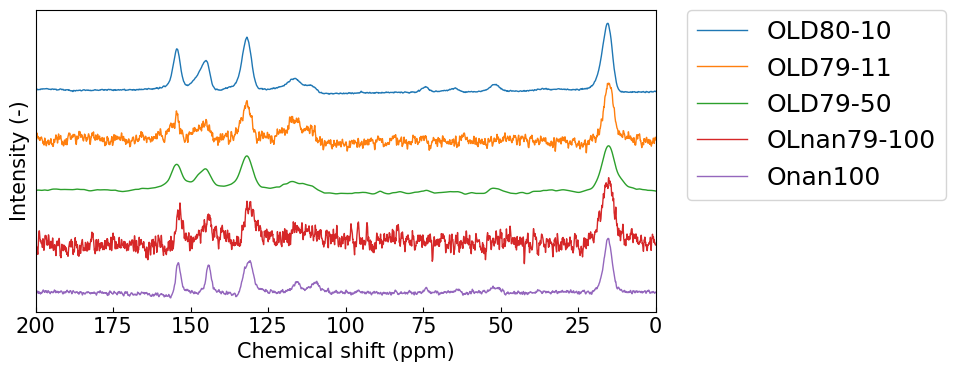

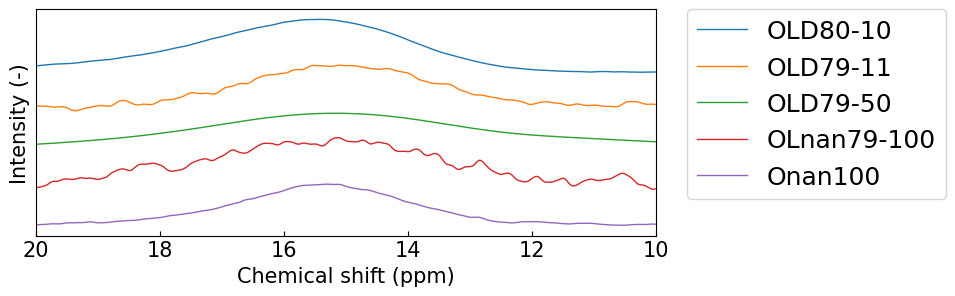

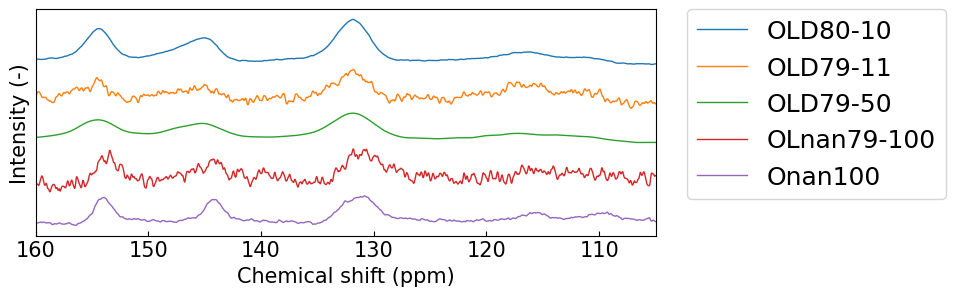

In [28]:
nmr_cond="solid_C_MAS_nmr"
current_df=sel_df[sel_df["solid_NMR_keyword"]==nmr_cond]


def d_carbon_plot(x_range):
    current_df2=current_df[current_df["manual condition"].str.find("80-10")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),offset=0.04,scale=0.2,alpha=1)

    current_df2=current_df[current_df["manual condition"].str.find("11")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),offset=0.02,scale=0.25,alpha=1)

    current_df2=current_df[current_df["manual condition"].str.find("79-50")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),scale=1.5,offset=0,alpha=1)

    current_df2=current_df[current_df["manual condition"].str.find("nan79")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),scale=3.5,alpha=1,offset=-0.02)

    current_df2=current_df[current_df["manual condition"].str.find("nan100")>=0]
    auto_plot(current_df2,nmr_cond,x_range=(x_range[0],x_range[1]),scale=0.05,alpha=1,offset=-0.04)

    plt.yticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

    
x_range=(0,200)
prepare_fig(figsize=(8,4))
d_carbon_plot(x_range)


x_range=(10,20)
prepare_fig(figsize=(8,3))
d_carbon_plot(x_range)

x_range=(105,160)
prepare_fig(figsize=(8,3))
d_carbon_plot(x_range)